# Optogenetic Control of *Drosophila* Courtship Behavior
## Step 1: Segment Recordings
In this first step, the *Drosophila* recordings are algorithmically segmented into periods of sine song and pulse song using the [FlySongSegmenter](https://github.com/FlyCourtship/FlySongSegmenter) software [(Arther et al., 2013)](https://bmcbiol.biomedcentral.com/articles/10.1186/1741-7007-11-11). This software is available in Matlab only. A wrapper script, *SegmentWrapper.m*, was used to iteratively apply the software to each recording and dump the raw data, sine songs, and pulse songs into one file. 

**Note:** Using *FlySongSegmenter*, we use only the sine songs from *Sines.LengthCull* and the pulse songs from *Pulses.ModelCull2*. These are more conservative estimates of periods of fly song in the recordings. See the Github for details.

## Step 2: Everything else

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from scipy.io import loadmat
from scipy.stats import cauchy, gaussian_kde
from sklearn.preprocessing import MinMaxScaler
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
files = sorted([f for f in os.listdir('raw') if f.endswith('mat')])
sdict = dict(pair1='Wild 1', pair2='Wild 2', p10='pIP10', p1='P1')

## Waveform parameters.
n_samples = 100 # samples on either side of center
sfreq = 1e4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
cFREQ, IPI, WAVE = [], [], []

for f in files:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load mat file.
    mat = loadmat('raw/%s' %f)
    specimen, recording = f.replace('.mat','').split('_') 
    specimen = sdict[specimen]
    
    ## Extract data.
    raw, times, pulses = mat['d'], mat['times'], mat['pulses']
    times = times.squeeze()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Carrier frequency statistics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Create and append DataFrame.
    _, n_pulses = pulses.shape
    df = np.vstack([np.repeat(specimen, n_pulses),
                    np.repeat(recording, n_pulses),
                    np.repeat(times.max(), n_pulses),
                    pulses[-1]])
    df = DataFrame(df.T, columns=('Specimen','Recording','Duration','Carrier Frequency'))
    df['Carrier Frequency'] = df['Carrier Frequency'].astype(float)
    cFREQ.append(df)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Interpulse interval (IPI) statistics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Compute interpulse interval.
    ipi = np.diff(times[pulses[0]-1]) # 0-indexing
    
    ## Fit Cauchy (Student-t, df=1) to IPI.
    mu, sd = cauchy.fit(ipi)
    
    ## CDF threshold.
    CDF = cauchy(mu, sd).cdf(ipi)
    CDF = np.where(CDF > 0.5, 1 - CDF, CDF)
    ipi = ipi[CDF > 0.05]
    
    ## Create and append DataFrame.
    df = np.vstack([np.repeat(specimen, ipi.size),np.repeat(recording, ipi.size),ipi])
    df = DataFrame(df.T, columns=('Specimen','Recording','IPI'))
    df['IPI'] = df['IPI'].astype(float)
    IPI.append(df)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Waveform statistics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract waveforms.
    waveforms = []
    for loc in pulses[0] - 1: waveforms.append( raw[loc - n_samples:loc + n_samples + 1,0] )
    waveforms = np.array(waveforms)
    
    ## Create and append DataFrame.
    df = DataFrame(waveforms)
    df['Specimen'] = specimen
    df['Recording'] = recording
    df = df.melt(id_vars=('Specimen','Recording'), var_name='Time', value_name='uV')
    WAVE.append(df)
    
## Concatenate DataFrames.
cFREQ, IPI, WAVE = concat(cFREQ), concat(IPI), concat(WAVE)


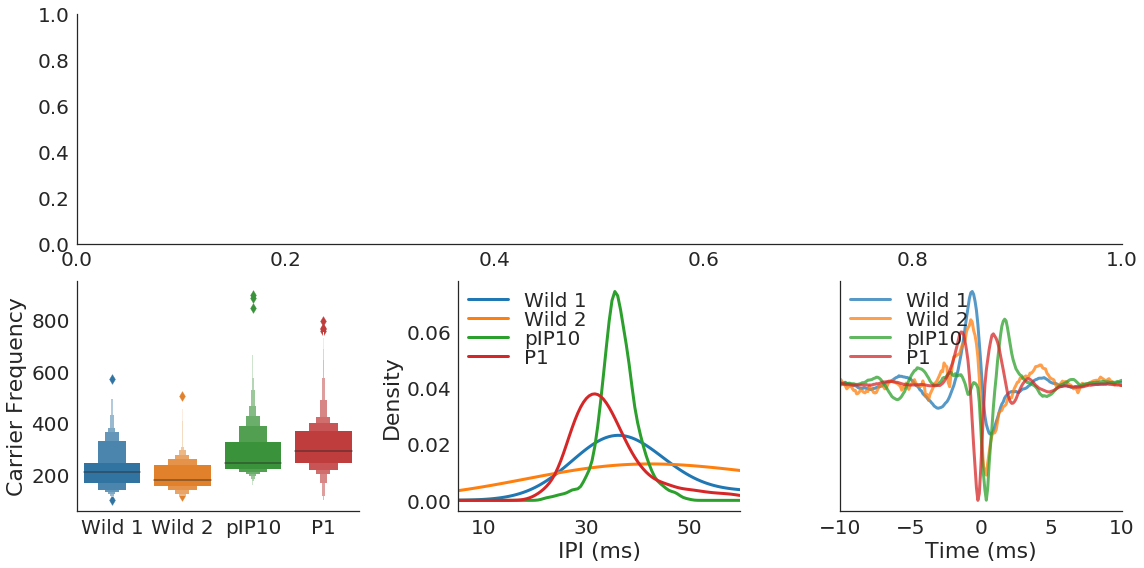

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(16,8))
order = ['Wild 1', 'Wild 2', 'pIP10', 'P1']

## Plot representative recording.
ax = plt.subplot2grid((2,3),(0,0),colspan=3)

## Plot carrier frequency.
ax = plt.subplot2grid((2,3),(1,0))
sns.lvplot('Specimen', 'Carrier Frequency', data=cFREQ, order=order)
ax.set(xlabel='')

## Plot IPI.
ax = plt.subplot2grid((2,3),(1,1))
x = np.linspace(5e-3,6e-2,100)
for specimen in order:    
    kde = gaussian_kde(IPI.loc[IPI.Specimen==specimen,'IPI'], bw_method='scott')
    y = kde(x)
    ax.plot(x*1e3, y/y.sum(), lw=3, label=specimen)
ax.set(xlim=(5,60), xticks=[10,30,50], xlabel='IPI (ms)', ylabel='Density')
ax.legend(loc=2,borderpad=0,labelspacing=0)    

## Plot waveforms.
ax = plt.subplot2grid((2,3),(1,2))
gb = WAVE.groupby(['Specimen','Time']).uV.mean()
zscore = lambda arr: (arr - arr.mean()) / arr.std()
for specimen in order:
    y = zscore(gb[specimen])
    x = np.linspace(-n_samples/sfreq,n_samples/sfreq,y.size)*1e3
    ax.plot(x, y, lw=3, label=specimen, alpha=0.75)
ax.set(xlim=(-10,10), xlabel='Time (ms)', yticks=[])
ax.legend(loc=2,borderpad=0,labelspacing=0)

sns.despine()
plt.tight_layout()